# Gaussian

1D와 2D gaussian_mask를 직접 만들고, 이미지에 적용하는 함수입니다.
그리고 각 mask를 적용했을때 차이점을 살펴봅시다

In [1]:
import numpy as np
import cv2
import my_padding as my_p
import time
import matplotlib.pyplot as plt

## my_get_Gaussian2D_mask

In [2]:
def my_get_Gaussian2D_mask(msize, sigma=1):
    y, x = np.mgrid[-(msize // 2):(msize // 2) + 1, -(msize // 2):(msize // 2) + 1]
    '''
    y, x = np.mgrid[-1:2, -1:2]
    y = [[-1,-1,-1],
         [ 0, 0, 0],
         [ 1, 1, 1]]
    x = [[-1, 0, 1],
         [-1, 0, 1],
         [-1, 0, 1]]
    '''
    #2차 gaussian mask 생성
    gaus2D =   1 / (2 * np.pi * sigma**2) * np.exp(-(( x**2 + y**2 )/(2 * sigma**2)))

    #mask의 총 합 = 1
    gaus2D /= np.sum(gaus2D)

    return gaus2D

x, y의 의미는 x,y축으로의 증가와 감소를 의미합니다. x,y를 적용한 gaus2D를 만들고, 밝기는 유지하기위해 sum을 나눠줍니다.

## my_get_Gaussian1D_mask

In [3]:
def my_get_Gaussian1D_mask(msize, sigma=1):


    x = np.linspace(-(msize-1)//2, (msize-1)//2, msize)
    x = np.reshape(x, (1, msize))
    gaus1D =  1 / (np.sqrt(2 * np.pi )* sigma) * np.exp(-(( x**2)/(2 * sigma**2)))


    gaus1D /= np.sum(gaus1D)
    return gaus1D

gaus2D와 다르게, 1차원만 다룬 함수입니다. linspace를 통해 [-2, -1, 0, 1, 2]와 같은 형식으로 x를 만듭니다. mask로 사용하기 위해선 2차원이 필요하기 때문에 reshape를 통해 (1, x)로 만들고, gaus1D를 생성합니다

## my_filtering

In [4]:
def my_filtering(src, mask, pad_type = 'zero'):
    (h, w) = src.shape

    #mask의 크기
    (m_h, m_w) = mask.shape

    #mask 확인
    #print('<mask>')
    #print(mask)

    # 직접 구현한 my_padding 함수를 이용
    pad_img = my_p.my_padding(src, (m_h//2, m_w//2), pad_type)

    dst = np.zeros((h, w))

    #시간을 확인하려면 4중 for문을 이용해야함
    for row in range(h):
        for col in range(w):
            sum = 0
            for m_row in range(m_h):
                for m_col in range(m_w):
                    sum += pad_img[row + m_row, col+m_col] * mask[m_row, m_col]
            dst[row, col] = sum
    '''
    #4중 for문 시간이 오래걸릴 경우 해당 코드 사용(시간을 확인하려면 해당 코드를 사용하면 안됨)
    for row in range(h):
        for col in range(w):
            dst[row, col] = np.sum(pad_img[row:row + m_h, col:col + m_w] * mask)
    '''
    return dst

gaus1D와 gaus2D mask중 하나를 선택해 이미지에 적용하는 함수입니다.

mask size :  3
1D gaussian filter
1D time :  1.4164131060000003
2D gaussian filter
2D time :  1.6564247990000016
count :  0


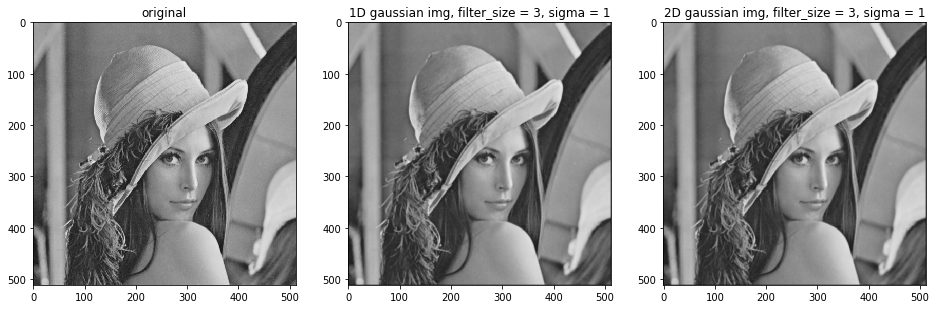

In [5]:
if __name__ == '__main__':
    src = cv2.imread('Lena.png', cv2.IMREAD_GRAYSCALE)
    mask_size = 3
    gaus2D = my_get_Gaussian2D_mask(mask_size, sigma = 1)
    gaus1D = my_get_Gaussian1D_mask(mask_size, sigma = 1)

    #mask size 출력
    print('mask size : ', mask_size)

    #1차 가우시안 필터 적용 및 시간 재기
    print('1D gaussian filter')
    start = time.perf_counter()  # 시간 측정 시작
    dst_gaus1D= my_filtering(src, gaus1D)
    dst_gaus1D= my_filtering(dst_gaus1D, gaus1D.T)
    dst_gaus1D = (dst_gaus1D + 0.5).astype(np.uint8)
    end = time.perf_counter()  # 시간 측정 끝
    print('1D time : ', end-start)

    #2차 가우시안 필터 적용 및 시간 재기
    print('2D gaussian filter')
    start = time.perf_counter()  # 시간 측정 시작
    dst_gaus2D= my_filtering(src, gaus2D)
    dst_gaus2D = (dst_gaus2D + 0.5).astype(np.uint8)
    end = time.perf_counter()  # 시간 측정 끝
    print('2D time : ', end-start)

    #1차 가우시안 필터와 2차 가우시안 필터 비교, 차이가 없으면 count = 0
    (h, w) = dst_gaus1D.shape #(h, w) = dst_gaus2D.shape
    count = 0
    for i in range(h):
        for j in range(w):
            if dst_gaus1D[i, j] != dst_gaus2D[i, j]:
                count += 1 #두 값이 다르면 count += 1
    print('count : ', count)
    
    
    #결과 이미지 출력
    
    fig, ax = plt.subplots(1,3, figsize = (16,9))
    
    ax[0].set_title('original')
    ax[0].imshow(cv2.cvtColor(src,cv2.COLOR_GRAY2RGB))
    
    ax[1].set_title('1D gaussian img, filter_size = 3, sigma = 1')
    ax[1].imshow(cv2.cvtColor(dst_gaus1D,cv2.COLOR_GRAY2RGB))
    
    ax[2].set_title('2D gaussian img, filter_size = 3, sigma = 1')
    ax[2].imshow(cv2.cvtColor(dst_gaus2D,cv2.COLOR_GRAY2RGB))
    plt.show()



1D gaussian filter, 2D gaussian filter를 적용하고 걸린 시간과 각 값 차이를 나타냅니다.
count는 1d gaus, 2d gaus를 적용한 이미지의 값을 비교해 다른 개수를 return 합니다.

1. count = 0 : 1d와 2d를 적용한 이미지의 값 차이가 0 즉 결과가 같습니다. 이를 통해 1차원과 2차원은 같은 결과를 만들어내고, 2차원 배열의 계산이 시간이 더 오래걸리기 때문에 1차원 계산이 효율적임을 알 수 있습니다. 

2. filter_size와 sigma값이 바뀔면 이미지에 어떤 변화가 오는지 알아봅시다

## 비교

filter_size, sigma에 따라 나오는 이미지와 시간 차이를 비교하기위해 함수를 만들어 보았습니다.

In [6]:
def compare_time(src, mask_size, sigma):
    src = cv2.imread('Lena.png', cv2.IMREAD_GRAYSCALE)
    gaus2D = my_get_Gaussian2D_mask(mask_size, sigma)
    gaus1D = my_get_Gaussian1D_mask(mask_size, sigma)

    
    #mask size 출력
    print('mask size : ', mask_size)

    #1차 가우시안 필터 적용 및 시간 재기
    print('1D gaussian filter')
    start = time.perf_counter()  # 시간 측정 시작
    dst_gaus1D= my_filtering(src, gaus1D)
    dst_gaus1D= my_filtering(dst_gaus1D, gaus1D.T)
    dst_gaus1D = (dst_gaus1D + 0.5).astype(np.uint8)
    end = time.perf_counter()  # 시간 측정 끝
    print('1D time : ', end-start)
    
    #2차 가우시안 필터 적용 및 시간 재기
    print('2D gaussian filter')
    start = time.perf_counter()  # 시간 측정 시작
    dst_gaus2D= my_filtering(src, gaus2D)
    dst_gaus2D = (dst_gaus2D + 0.5).astype(np.uint8)
    end = time.perf_counter()  # 시간 측정 끝
    print('2D time : ', end-start)
    
    print('')
    print('')
    
    return dst_gaus1D, dst_gaus2D

In [7]:
def compare_img(src,dst_gaus1D, dst_gaus2D, mask, sigma):
    
    fig, ax = plt.subplots(1,3, figsize = (16,9))
    
    ax[0].set_title('original')
    ax[0].imshow(cv2.cvtColor(src,cv2.COLOR_GRAY2RGB))
    
    ax[1].set_title('1D gaussian img, filter_size = '+str(mask)+', sigma = '+str(sigma))
    ax[1].imshow(cv2.cvtColor(dst_gaus1D,cv2.COLOR_GRAY2RGB))
    
    ax[2].set_title('2D gaussian img, filter_size = '+str(mask)+', sigma = '+str(sigma))
    ax[2].imshow(cv2.cvtColor(dst_gaus2D,cv2.COLOR_GRAY2RGB))
    plt.show()
    print(" ")

In [8]:
# mask = 3, sigma = 1
mask_3_sigma_1_1D,mask_3_sigma_1_2D = compare_time(src, 3, 1)

# mask = 10, sigma = 1
mask_10_sigma_1_1D,mask_10_sigma_1_2D = compare_time(src, 10, 1)

# mask = 15, sigma = 1
mask_15_sigma_1_1D,mask_15_sigma_1_2D = compare_time(src, 15, 1)

# mask = 30, sigma = 1
mask_30_sigma_1_1D,mask_30_sigma_1_2D = compare_time(src, 30, 1)

mask size :  3
1D gaussian filter
1D time :  1.3876543979999987
2D gaussian filter
2D time :  1.6358235240000027


mask size :  10
1D gaussian filter
1D time :  3.6537854629999984
2D gaussian filter
2D time :  17.382511484000002


mask size :  15
1D gaussian filter
1D time :  5.269338818999998
2D gaussian filter
2D time :  31.390549028000002


mask size :  30
1D gaussian filter
1D time :  10.018461596999998
2D gaussian filter
2D time :  130.249575714




앞서 1d, 2d mask의 결과물이 같다는것을 알아내 값 비교는 제외했습니다. sigma = 1로 유지하고, mask_size는 점점 올려보았습니다. mask_size = 3 에서는 1d, 2d의 속도차이도 거의 없고 빨랐지만, mask 값이 커지면 커질수록 1d가 월등히 빠른것을 알 수 있습니다. 또 mask_size가 커질수록 연산양이 많아져 이미지를 만드는 시간이 길어집니다.

다음은 결과물을 확인해 보겠습니다.

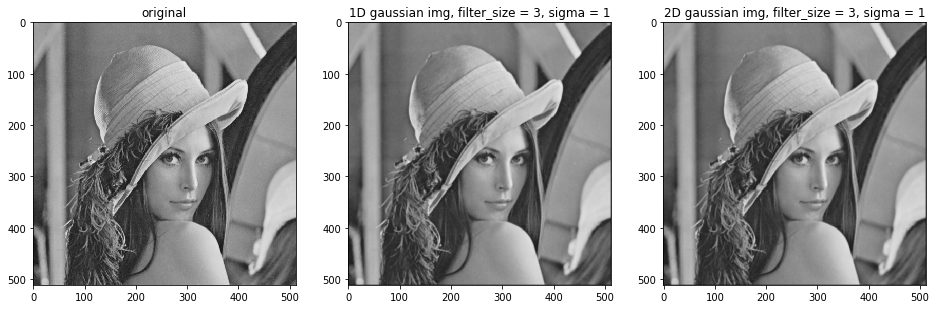

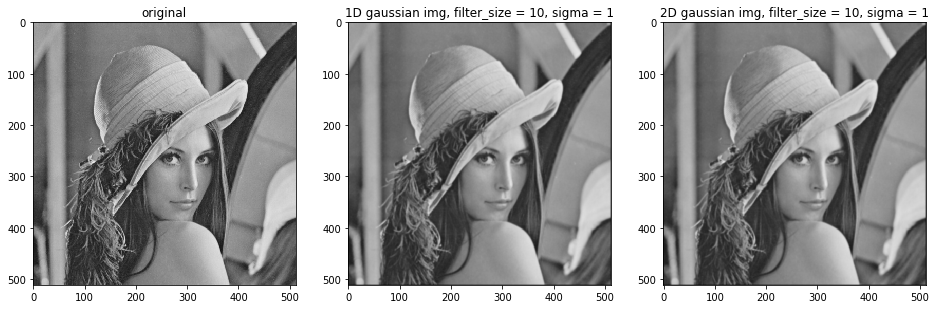

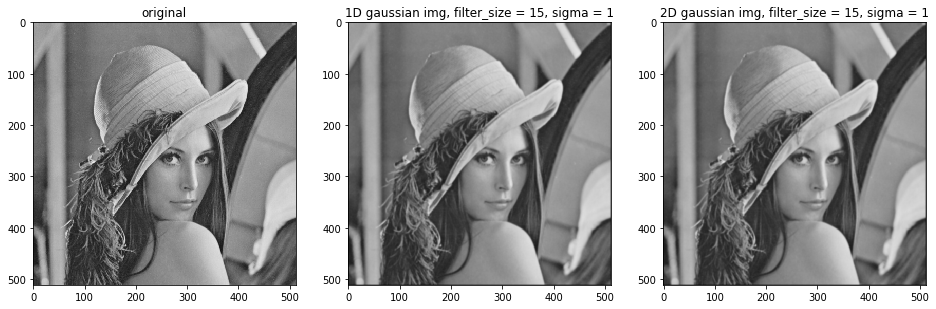

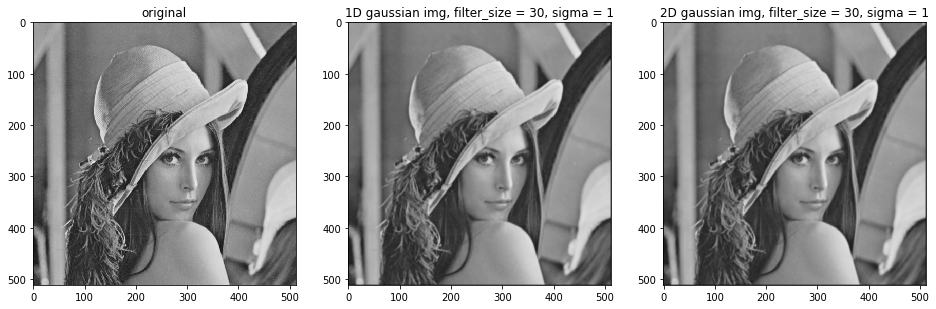

In [9]:
compare_img(src,mask_3_sigma_1_1D,mask_3_sigma_1_2D,3,1)

compare_img(src,mask_10_sigma_1_1D,mask_10_sigma_1_2D,10,1)
            
compare_img(src,mask_15_sigma_1_1D,mask_15_sigma_1_2D,15,1)

compare_img(src,mask_30_sigma_1_1D,mask_30_sigma_1_2D,30,1)

filter_size가 커지면 시간은 오래 걸리지만, gaussian식을 생각해보면 끝 값을 조금만 들고오기 때문인지 시각적인 차이를 느끼기는 힘들었습니다. 

In [10]:
# mask = 3, sigma = 1
mask_3_sigma_1_1D,mask_3_sigma_1_2D = compare_time(src, 3, 1)

# mask = 3, sigma = 10
mask_3_sigma_10_1D,mask_3_sigma_10_2D = compare_time(src, 3, 10)

# mask = 3, sigma = 50
mask_3_sigma_50_1D,mask_3_sigma_50_2D = compare_time(src, 3, 50)

# mask = 3, sigma = 100
mask_3_sigma_100_1D,mask_3_sigma_100_2D = compare_time(src, 3, 100)

mask size :  3
1D gaussian filter
1D time :  1.4023789629999897
2D gaussian filter
2D time :  1.6592735889999801


mask size :  3
1D gaussian filter
1D time :  1.4024977960000058
2D gaussian filter
2D time :  1.6590581400000133


mask size :  3
1D gaussian filter
1D time :  1.4067471780000176
2D gaussian filter
2D time :  1.6502060520000157


mask size :  3
1D gaussian filter
1D time :  1.4113636360000044
2D gaussian filter
2D time :  1.6467507609999927




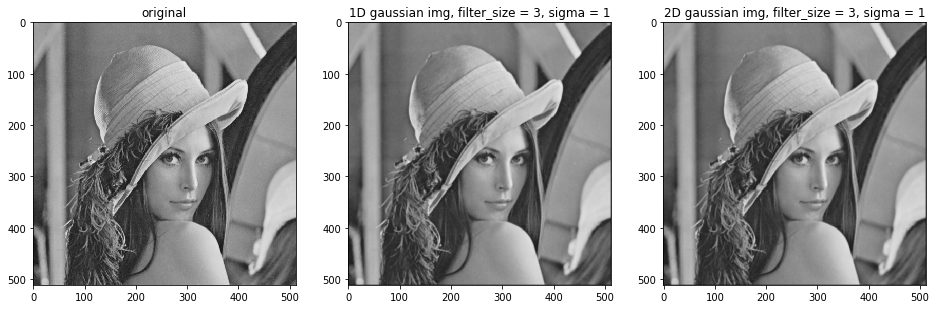

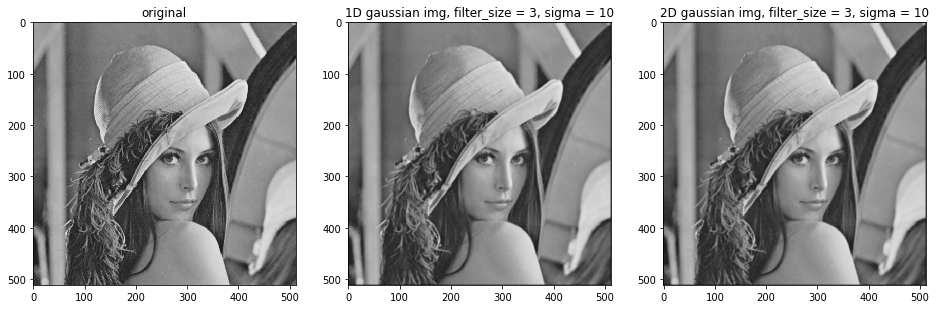

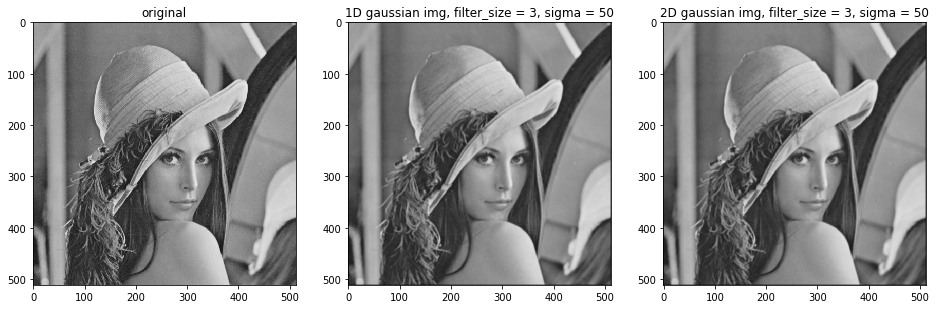

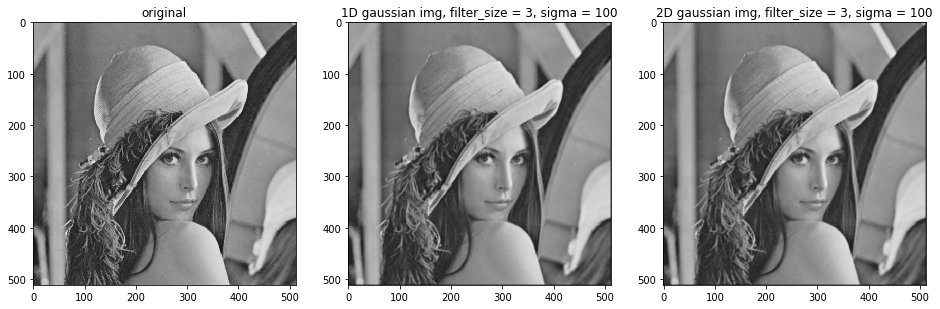

In [11]:
compare_img(src,mask_3_sigma_1_1D,mask_3_sigma_1_2D,3,1)

compare_img(src,mask_3_sigma_10_1D,mask_3_sigma_10_2D,3,10)
            
compare_img(src,mask_3_sigma_50_1D,mask_3_sigma_50_2D,3,50)

compare_img(src,mask_3_sigma_100_1D,mask_3_sigma_100_2D,3,100)

filter size를 고정하고 sigma만 수정해 보았습니다. filter가 작기 때문에  sigma가 커지더라도 이미지 변화가 크지 않습니다.

In [12]:
# mask = 3, sigma = 50
mask_3_sigma_1_1D,mask_3_sigma_50_2D = compare_time(src, 3, 50)

# mask = 10, sigma = 50
mask_10_sigma_10_1D,mask_10_sigma_50_2D = compare_time(src, 10, 50)

# mask = 15, sigma = 50
mask_15_sigma_15_1D,mask_15_sigma_50_2D = compare_time(src, 15, 50)

# mask = 30, sigma = 50
mask_30_sigma_30_1D,mask_30_sigma_50_2D = compare_time(src, 30, 50)

mask size :  3
1D gaussian filter
1D time :  1.4096989329999872
2D gaussian filter
2D time :  1.6451720960000102


mask size :  10
1D gaussian filter
1D time :  3.780469339000007
2D gaussian filter
2D time :  17.705071086000004


mask size :  15
1D gaussian filter
1D time :  5.475616030000026
2D gaussian filter
2D time :  32.629030011


mask size :  30
1D gaussian filter
1D time :  10.46452976300003
2D gaussian filter
2D time :  134.087512752




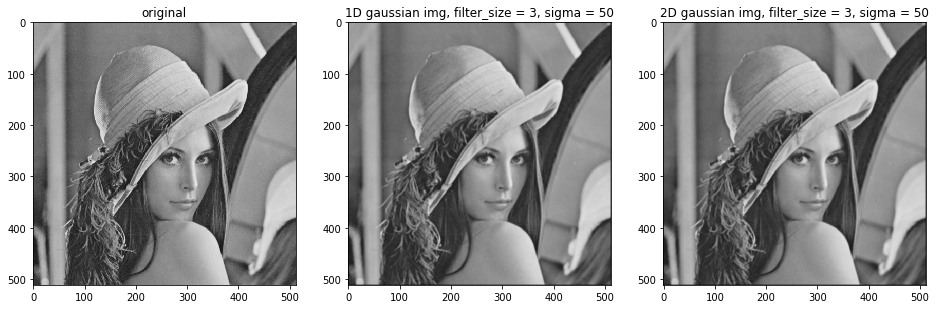

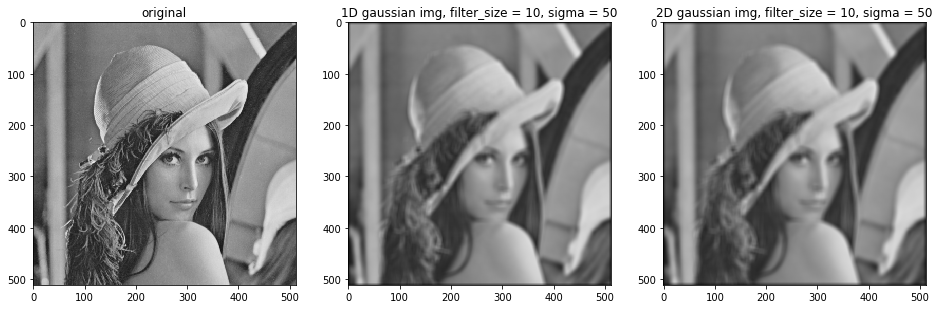

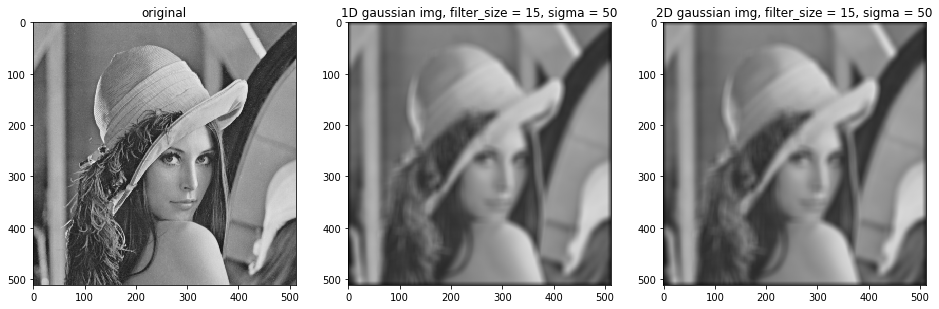

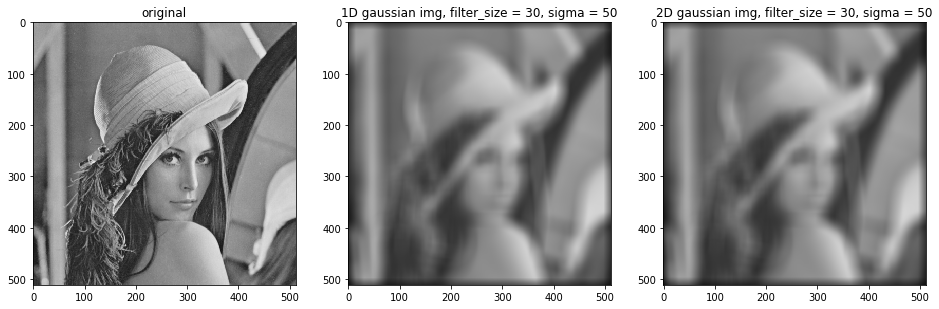

In [13]:
compare_img(src,mask_3_sigma_1_1D,mask_3_sigma_50_2D,3,50)

compare_img(src,mask_10_sigma_10_1D,mask_10_sigma_50_2D,10,50)
            
compare_img(src,mask_15_sigma_15_1D,mask_15_sigma_50_2D,15,50)

compare_img(src,mask_30_sigma_30_1D,mask_30_sigma_50_2D,30,50)

filter_size와 sigma중 하나만 높은건 의미가 없는 것 같아 위와 같이 진행했습니다.
이를 통해 sigma와 filter_size 모두 적당히 높아야 gaussian filter 효과가 잘 나옵니다.(smoothing)

## 결론

1. 1D gaussian_mask와 2D gaussian_mask의 적용 결과는 같지만, 1D가 2D보다 빠릅니다.

2. filter_size와 sigma 모두 높아야 gaussian 효과를 많이 봅니다.